In [2]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: keras
    Found existing installation: keras 3.0.5
    Uninstalling keras-3.0.5:
      Successfully uninstalled keras-3.0.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow import keras

%matplotlib inline
import matplotlib.pyplot as plt

## Loading and prepocessing the dataset

In [7]:
data = np.load('/kaggle/input/qg-jets/QG_jets.npz',allow_pickle=True)
X = data['X']
y = tf.keras.utils.to_categorical(data['y'])

X, y = shuffle(X, y, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(70000, 139, 4) (70000, 2)
(15000, 139, 4) (15000, 2)
(15000, 139, 4) (15000, 2)


In [11]:
train_dict = {
    'points' : X_train[:,:,1:3],
    'features' : X_train,
    'mask': np.sum(X_train, axis=2).reshape(len(X_train), X_train.shape[1], 1)
    }

val_dict = {
    'points' : X_val[:,:,1:3],
    'features' : X_val,
    'mask': np.sum(X_val, axis=2).reshape(len(X_val), X_val.shape[1], 1)
    }

test_dict = {
    'points' : X_test[:,:,1:3],
    'features' : X_test,
    'mask': np.sum(X_test, axis=2).reshape(len(X_test), X_test.shape[1], 1)
    }

# Initializing the Models

In [7]:
from tensorflow import keras

In [13]:
import tensorflow as tf
from tensorflow import keras


# A shape is (N, P_A, C), B shape is (N, P_B, C)
# D shape is (N, P_A, P_B)
def batch_distance_matrix_general(A, B):
    with tf.name_scope('dmat'):
        r_A = tf.reduce_sum(A * A, axis=2, keepdims=True)
        r_B = tf.reduce_sum(B * B, axis=2, keepdims=True)
        m = tf.matmul(A, tf.transpose(B, perm=(0, 2, 1)))
        D = r_A - 2 * m + tf.transpose(r_B, perm=(0, 2, 1))
        return D


def knn(num_points, k, topk_indices, features):
    # topk_indices: (N, P, K)
    # features: (N, P, C)
    with tf.name_scope('knn'):
        queries_shape = tf.shape(features)
        batch_size = queries_shape[0]
        batch_indices = tf.tile(tf.reshape(tf.range(batch_size), (-1, 1, 1, 1)), (1, num_points, k, 1))
        indices = tf.concat([batch_indices, tf.expand_dims(topk_indices, axis=3)], axis=3)  # (N, P, K, 2)
        return tf.gather_nd(features, indices)


def edge_conv(points, features, num_points, K, channels, with_bn=True, activation='relu', pooling='average', name='edgeconv'):
    """EdgeConv
    Args:
        K: int, number of neighbors
        in_channels: # of input channels
        channels: tuple of output channels
        pooling: pooling method ('max' or 'average')
    Inputs:
        points: (N, P, C_p)
        features: (N, P, C_0)
    Returns:
        transformed points: (N, P, C_out), C_out = channels[-1]
    """

    with tf.name_scope('edgeconv'):

        # distance
        D = batch_distance_matrix_general(points, points)  # (N, P, P)
        _, indices = tf.nn.top_k(-D, k=K + 1)  # (N, P, K+1)
        indices = indices[:, :, 1:]  # (N, P, K)

        fts = features
        knn_fts = knn(num_points, K, indices, fts)  # (N, P, K, C)
        knn_fts_center = tf.tile(tf.expand_dims(fts, axis=2), (1, 1, K, 1))  # (N, P, K, C)
        knn_fts = tf.concat([knn_fts_center, tf.subtract(knn_fts, knn_fts_center)], axis=-1)  # (N, P, K, 2*C)

        x = knn_fts
        for idx, channel in enumerate(channels):
            x = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=1, data_format='channels_last',
                                    use_bias=False if with_bn else True, kernel_initializer='glorot_normal', name='%s_conv%d' % (name, idx))(x)
            if with_bn:
                x = keras.layers.BatchNormalization(name='%s_bn%d' % (name, idx))(x)
            if activation:
                x = keras.layers.Activation(activation, name='%s_act%d' % (name, idx))(x)

        if pooling == 'max':
            fts = tf.reduce_max(x, axis=2)  # (N, P, C')
        else:
            fts = tf.reduce_mean(x, axis=2)  # (N, P, C')

        # shortcut
        sc = keras.layers.Conv2D(channels[-1], kernel_size=(1, 1), strides=1, data_format='channels_last',
                                 use_bias=False if with_bn else True, kernel_initializer='glorot_normal', name='%s_sc_conv' % name)(tf.expand_dims(features, axis=2))
        if with_bn:
            sc = keras.layers.BatchNormalization(name='%s_sc_bn' % name)(sc)
        sc = tf.squeeze(sc, axis=2)

        if activation:
            return keras.layers.Activation(activation, name='%s_sc_act' % name)(sc + fts)  # (N, P, C')
        else:
            return sc + fts


def _particle_net_base(points, features=None, mask=None, setting=None, name='particle_net'):
    # points : (N, P, C_coord)
    # features:  (N, P, C_features), optional
    # mask: (N, P, 1), optinal

    with tf.name_scope(name):
        if features is None:
            features = points

        if mask is not None:
            mask = tf.cast(tf.not_equal(mask, 0), dtype='float32')  # 1 if valid
            coord_shift = tf.multiply(999., tf.cast(tf.equal(mask, 0), dtype='float32'))  # make non-valid positions to 99

        fts = tf.squeeze(keras.layers.BatchNormalization(name='%s_fts_bn' % name)(tf.expand_dims(features, axis=2)), axis=2)
        for layer_idx, layer_param in enumerate(setting.conv_params):
            K, channels = layer_param
            pts = tf.add(coord_shift, points) if layer_idx == 0 else tf.add(coord_shift, fts)
            fts = edge_conv(pts, fts, setting.num_points, K, channels, with_bn=True, activation='relu',
                            pooling=setting.conv_pooling, name='%s_%s%d' % (name, 'EdgeConv', layer_idx))

        if mask is not None:
            fts = tf.multiply(fts, mask)

        pool = tf.reduce_mean(fts, axis=1)  # (N, C)

        if setting.fc_params is not None:
            x = pool
            for layer_idx, layer_param in enumerate(setting.fc_params):
                units, drop_rate = layer_param
                x = keras.layers.Dense(units, activation='relu')(x)
                if drop_rate is not None and drop_rate > 0:
                    x = keras.layers.Dropout(drop_rate)(x)
            out = keras.layers.Dense(setting.num_class, activation='softmax')(x)
            return out  # (N, num_classes)
        else:
            return pool


class _DotDict:
    pass


def get_particle_net(num_classes, input_shapes):
    r"""ParticleNet model from `"ParticleNet: Jet Tagging via Particle Clouds"
    <https://arxiv.org/abs/1902.08570>`_ paper.
    Parameters
    ----------
    num_classes : int
        Number of output classes.
    input_shapes : dict
        The shapes of each input (`points`, `features`, `mask`).
    """
    setting = _DotDict()
    setting.num_class = num_classes
    # conv_params: list of tuple in the format (K, (C1, C2, C3))
    setting.conv_params = [
        (16, (64, 64, 64)),
        (16, (128, 128, 128)),
        (16, (256, 256, 256)),
        ]
    # conv_pooling: 'average' or 'max'
    setting.conv_pooling = 'average'
    # fc_params: list of tuples in the format (C, drop_rate)
    setting.fc_params = [(256, 0.1)]
    setting.num_points = input_shapes['points'][0]

    points = keras.Input(name='points', shape=input_shapes['points'])
    features = keras.Input(name='features', shape=input_shapes['features']) if 'features' in input_shapes else None
    mask = keras.Input(name='mask', shape=input_shapes['mask']) if 'mask' in input_shapes else None
    outputs = _particle_net_base(points, features, mask, setting, name='ParticleNet')

    return keras.Model(inputs=[points, features, mask], outputs=outputs, name='ParticleNet')


def get_particle_net_lite(num_classes, input_shapes):
    r"""ParticleNet-Lite model from `"ParticleNet: Jet Tagging via Particle Clouds"
    <https://arxiv.org/abs/1902.08570>`_ paper.
    Parameters
    ----------
    num_classes : int
        Number of output classes.
    input_shapes : dict
        The shapes of each input (`points`, `features`, `mask`).
    """
    setting = _DotDict()
    setting.num_class = num_classes
    # conv_params: list of tuple in the format (K, (C1, C2, C3))
    setting.conv_params = [
        (7, (32, 32, 32)),
        (7, (64, 64, 64)),
        ]
    # conv_pooling: 'average' or 'max'
    setting.conv_pooling = 'average'
    # fc_params: list of tuples in the format (C, drop_rate)
    setting.fc_params = [(128, 0.1)]
    setting.num_points = input_shapes['points'][0]

    points = keras.Input(name='points', shape=input_shapes['points'])
    features = keras.Input(name='features', shape=input_shapes['features']) if 'features' in input_shapes else None
    mask = keras.Input(name='mask', shape=input_shapes['mask']) if 'mask' in input_shapes else None
    outputs = _particle_net_base(points, features, mask, setting, name='ParticleNet')

    return keras.Model(inputs=[points, features, mask], outputs=outputs, name='ParticleNet')

In [14]:
num_classes = 2
input_shapes = {k:train_dict[k].shape[1:] for k in train_dict}
print(input_shapes)

{'points': (139, 2), 'features': (139, 4), 'mask': (139, 1)}


In [15]:
model_lite = get_particle_net_lite(num_classes,input_shapes)

### Hyperparameters

In [21]:
batch_size = 300
epochs = 20

In [17]:
# learning rate schedule
def lr_schedule(epochs):
    learning_rate = 0.001
#     if epochs>10:
#         learning_rate*=0.1
#     if epochs>20:
#         learning_rate*=0.01
#     logging.info('Learning rate: %f'%learning_rate)
    return learning_rate

# ParticleNet Lite 

In [ ]:
model_lite.compile(loss = 'categorical_crossentropy',
             optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
             metrics=['accuracy',tf.keras.metrics.AUC()])
model_lite.summary()

Model: "ParticleNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 mask (InputLayer)           [(None, 139, 1)]             0         []                            
                                                                                                  
 tf.math.not_equal (TFOpLam  (None, 139, 1)               0         ['mask[0][0]']                
 bda)                                                                                             
                                                                                                  
 tf.cast (TFOpLambda)        (None, 139, 1)               0         ['tf.math.not_equal[0][0]']   
                                                                                                  
 tf.math.equal (TFOpLambda)  (None, 139, 1)               0         ['tf.cast[0][0]']   

In [19]:
lr_scheduler=keras.callbacks.LearningRateScheduler(lr_schedule)
progress_bar = keras.callbacks.ProgbarLogger()
callbacks=[lr_scheduler,progress_bar]
print(train_dict['points'].shape)
print(train_dict['features'].shape)
print(train_dict['mask'].shape)

(70000, 139, 2)
(70000, 139, 4)
(70000, 139, 1)


## Train

In [20]:
history_dynamic = model_lite.fit(train_dict,
                   y_train, 
                   epochs=epochs,
                   batch_size=batch_size,
                   callbacks=callbacks,
                   validation_data=(val_dict,y_val),
                   shuffle=True)

Epoch 1/20
234/234 [==============================] - 406s 2s/sample - loss: 0.5000 - accuracy: 0.7656 - auc: 0.8386 - val_loss: 0.4931 - val_accuracy: 0.7633 - val_auc: 0.8444 - lr: 0.0010
Epoch 2/20
234/234 [==============================] - 398s 2s/sample - loss: 0.4730 - accuracy: 0.7825 - auc: 0.8566 - val_loss: 0.4629 - val_accuracy: 0.7899 - val_auc: 0.8638 - lr: 0.0010
Epoch 3/20
234/234 [==============================] - 392s 2s/sample - loss: 0.4634 - accuracy: 0.7886 - auc: 0.8631 - val_loss: 0.4702 - val_accuracy: 0.7872 - val_auc: 0.8620 - lr: 0.0010
Epoch 4/20
234/234 [==============================] - 395s 2s/sample - loss: 0.4565 - accuracy: 0.7935 - auc: 0.8675 - val_loss: 0.4459 - val_accuracy: 0.7968 - val_auc: 0.8739 - lr: 0.0010
Epoch 5/20
234/234 [==============================] - 399s 2s/sample - loss: 0.4511 - accuracy: 0.7965 - auc: 0.8710 - val_loss: 0.4458 - val_accuracy: 0.7972 - val_auc: 0.8741 - lr: 0.0010
Epoch 6/20
234/234 [==============================

## Loss

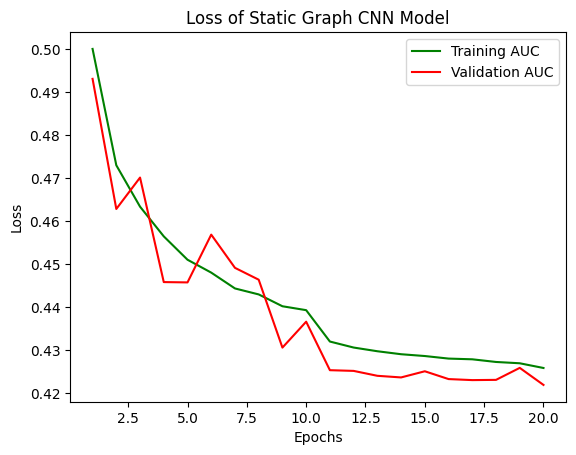

In [23]:
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_dynamic.history['loss'], color='green', label='Training AUC')
plt.plot(np.linspace(1,epochs,epochs, dtype=int), history_dynamic.history['val_loss'], color='red', label='Validation AUC')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss of Static Graph CNN Model")
plt.legend()
plt.show()